# read grace files

In [1]:
from grace.base import GraphAttrs
from grace.io import read_graph
from grace.napari.utils import EdgeColor
from pathlib import Path

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [2]:
dataset = read_graph(Path("/Users/arl/Desktop/annotations.grace"))

In [3]:
dataset.metadata

{'image_filename': 'FoilHole_24680421_Data_24671727_24671728_20181024_2216-78563_noDW'}

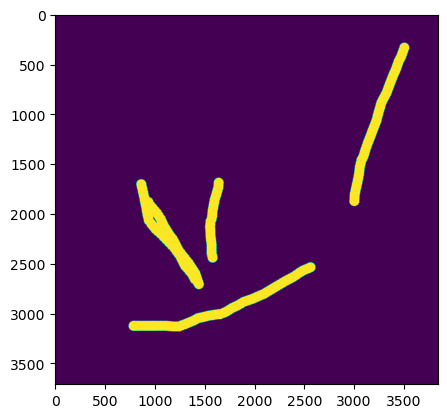

In [4]:
plt.imshow(dataset.annotation)

In [5]:
graph = dataset.graph

In [6]:
graph

In [7]:
graph.nodes(data=True)[0]

{<GraphAttrs.NODE_X: 'x'>: 1193.3724365234375,
 <GraphAttrs.NODE_Y: 'y'>: 3504.8525390625,
 <GraphAttrs.NODE_CONFIDENCE: 'confidence'>: 0.26680830121040344,
 <GraphAttrs.NODE_GROUND_TRUTH: 'node_ground_truth'>: <Annotation.UNKNOWN: 2>,
 <GraphAttrs.NODE_FEATURES: 'features'>: None}

Text(0.5, 1.0, 'FoilHole_24680421_Data_24671727_24671728_20181024_2216-78563_noDW')

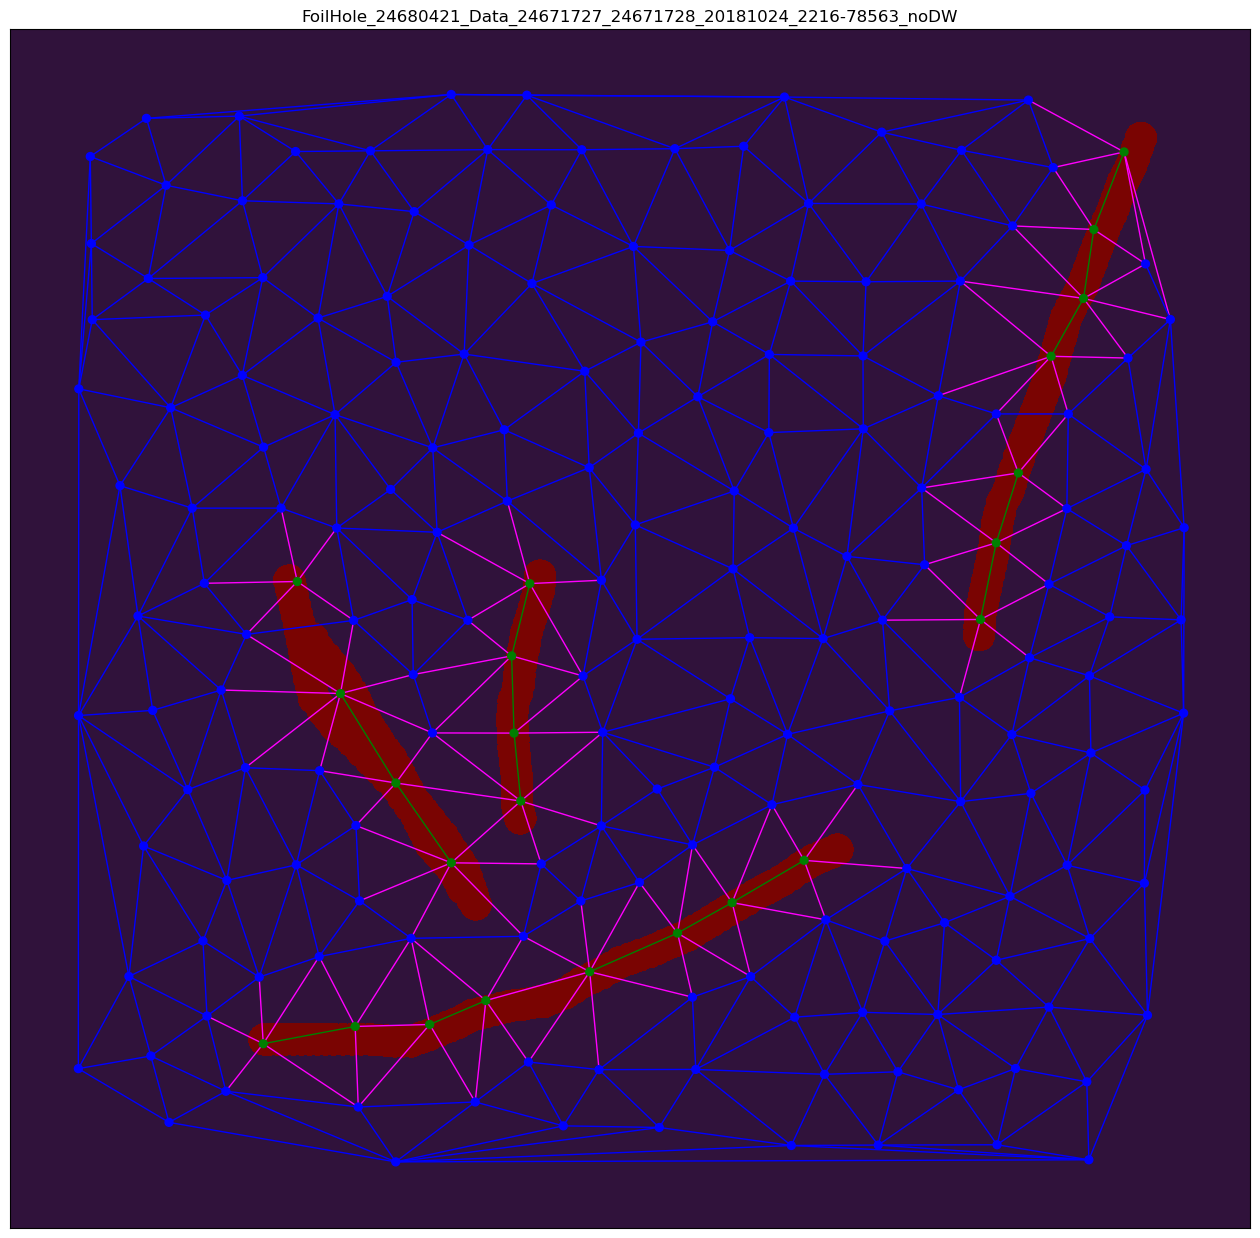

In [12]:

fig, ax = plt.subplots(figsize=(16, 16))

# node positions
pos = {
    idx: (node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]) 
    for idx, node in graph.nodes(data=True)
}
# edge annotations
edge_gt = [graph[u][v][GraphAttrs.EDGE_GROUND_TRUTH] for u, v in graph.edges]
edge_colors = [EdgeColor[gt.name].value for gt in edge_gt]

node_colors = [
    EdgeColor[node_attrs[GraphAttrs.NODE_GROUND_TRUTH].name].value 
    for _, node_attrs in graph.nodes(data=True)
]

ax.imshow(dataset.annotation, cmap=plt.cm.turbo, interpolation="none")

# draw all nodes/vertices in the graph, including those not determined to be 
# part of the objects
nx.draw_networkx(
    dataset.graph, 
    ax=ax, 
    pos=pos, 
    with_labels=False, 
    # node_color="w", 
    node_size=32,
    edge_color=edge_colors,
    node_color=node_colors,
)

ax.set_title(dataset.metadata["image_filename"])

In [9]:
np.unique(dataset.annotation)

array([0, 1])